# Binary Group Composition on $C_n$

**Group:** Cyclic group $C_n$ of order $p$ (i.e., modular addition mod $p$).  
**Task:** Given encodings of two group elements $a, b \in C_p$, predict the encoding of their product $a + b \pmod{p}$.  
**Sequence length:** $k = 2$ (binary composition).  
**Architecture:** `TwoLayerNet` with square nonlinearity.  
**Key result:** The network learns one Fourier mode at a time, producing a staircase in the training loss.

## Imports

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import src.dataset as dataset
import src.model as model
import src.optimizer as optimizer
import src.power as power
import src.template as template
import src.train as train_mod
import src.viz as viz

## Configuration

In [2]:
TEST_MODE = os.environ.get("NOTEBOOK_TEST_MODE", "0") == "1"

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

p = 11
hidden_size = 20 if TEST_MODE else 200
epochs = 2 if TEST_MODE else 5000
lr = 0.01
init_scale = 1e-5

FIGURES_DIR = "figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

## Template and Dataset

In [3]:
# Build a fixed Cn template with known Fourier structure
tpl = template.fixed_cn(
    group_size=p,
    fourier_coef_mags=[0, 12.5, 10, 7.5, 5, 2.5],
)

# Mean-center the template
tpl = tpl - np.mean(tpl)

# Build exhaustive dataset: all p^2 pairs
X, Y = dataset.cn_dataset(tpl)

# Move to tensors and flatten
X_tensor, Y_tensor, device = dataset.move_dataset_to_device_and_flatten(X, Y)

ds = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(ds, batch_size=len(ds), shuffle=False)

print(f"Group: C_{p}, order {p}")
print(f"Dataset: {len(ds)} samples (all {p}x{p} pairs)")
print(f"X shape: {X_tensor.shape}, Y shape: {Y_tensor.shape}")

Setting mode: 1 with magnitude: 12.5
Setting mode: 2 with magnitude: 10
Setting mode: 3 with magnitude: 7.5
Setting mode: 4 with magnitude: 5
Setting mode: 5 with magnitude: 2.5
GPU is available. Using CUDA.
Group: C_11, order 11
Dataset: 121 samples (all 11x11 pairs)
X shape: torch.Size([121, 22]), Y shape: torch.Size([121, 11])


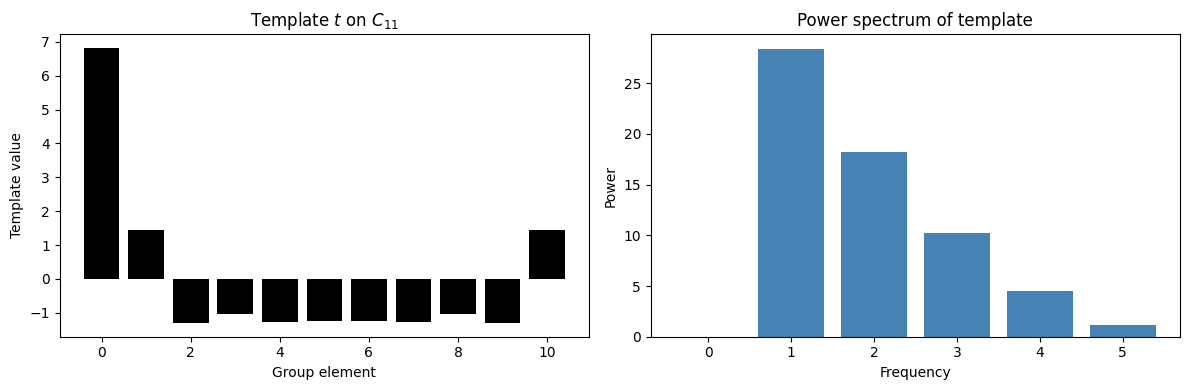

In [4]:
# Visualize template and its power spectrum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.bar(range(p), tpl, color="black")
ax1.set_xlabel("Group element")
ax1.set_ylabel("Template value")
ax1.set_title(f"Template $t$ on $C_{{{p}}}$")

pwr, freqs = power.get_power_1d(tpl)
ax2.bar(freqs, pwr, color="steelblue")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Power")
ax2.set_title("Power spectrum of template")

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cn_template.pdf", bbox_inches="tight")
plt.show()

## Model and Optimizer

In [5]:
net = model.TwoLayerNet(
    group_size=p,
    hidden_size=hidden_size,
    nonlinearity="square",
    init_scale=init_scale,
)
net = net.to(device)

criterion = nn.MSELoss()
opt = optimizer.PerNeuronScaledSGD(net, lr=lr, degree=3)

print(f"Model: TwoLayerNet(p={p}, hidden={hidden_size}, init_scale={init_scale})")
print(f"Optimizer: PerNeuronScaledSGD(lr={lr}, degree=3)")
print(f"Training for {epochs} epochs")

Model: TwoLayerNet(p=11, hidden=200, init_scale=1e-05)
Optimizer: PerNeuronScaledSGD(lr=0.01, degree=3)
Training for 5000 epochs


## Training

In [6]:
loss_history, val_loss_history, param_history, param_save_epochs, final_epoch = train_mod.train(
    net,
    dataloader,
    criterion,
    opt,
    epochs=epochs,
    verbose_interval=max(1, epochs // 10),
    save_param_interval=1,
)

[Epoch   500/5000] loss: 0.141917 | reduction:   97.5%
[Epoch  1000/5000] loss: 0.103960 | reduction:   98.2%
[Epoch  1500/5000] loss: 0.103631 | reduction:   98.2%
[Epoch  2000/5000] loss: 0.103321 | reduction:   98.2%
[Epoch  2500/5000] loss: 0.103311 | reduction:   98.2%
[Epoch  3000/5000] loss: 0.103157 | reduction:   98.2%
[Epoch  3500/5000] loss: 0.101198 | reduction:   98.2%
[Epoch  4000/5000] loss: 0.095021 | reduction:   98.3%
[Epoch  4500/5000] loss: 0.083760 | reduction:   98.5%
[Epoch  5000/5000] loss: 0.069925 | reduction:   98.8%


## Training Loss

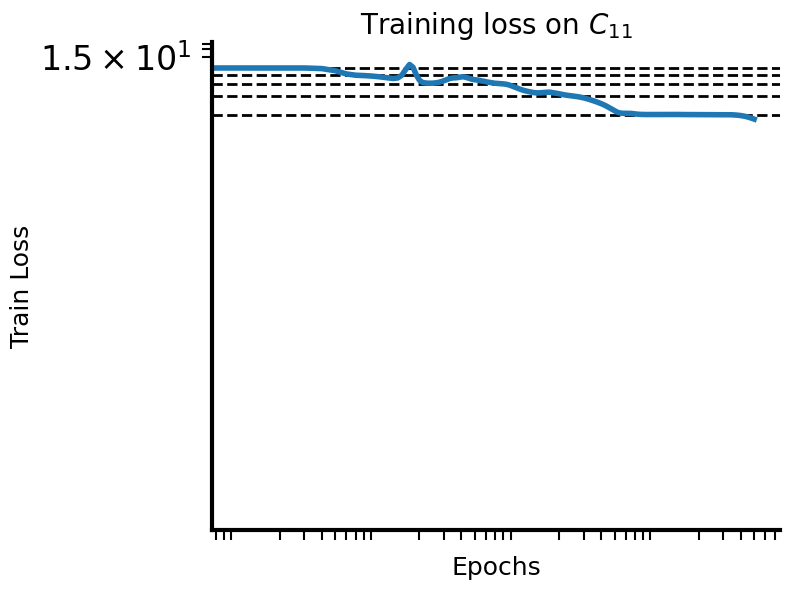

In [7]:
# Compute theoretical loss plateau levels
theory = power.theoretical_loss_levels_1d(tpl)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss_history, lw=4)

for level in theory["levels"]:
    ax.axhline(y=level, color="black", linestyle="--", linewidth=2, zorder=-2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Train Loss", fontsize=18)
ax.set_title(f"Training loss on $C_{{{p}}}$", fontsize=20)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cn_loss.pdf", bbox_inches="tight")
plt.show()

## Power Spectrum Over Training

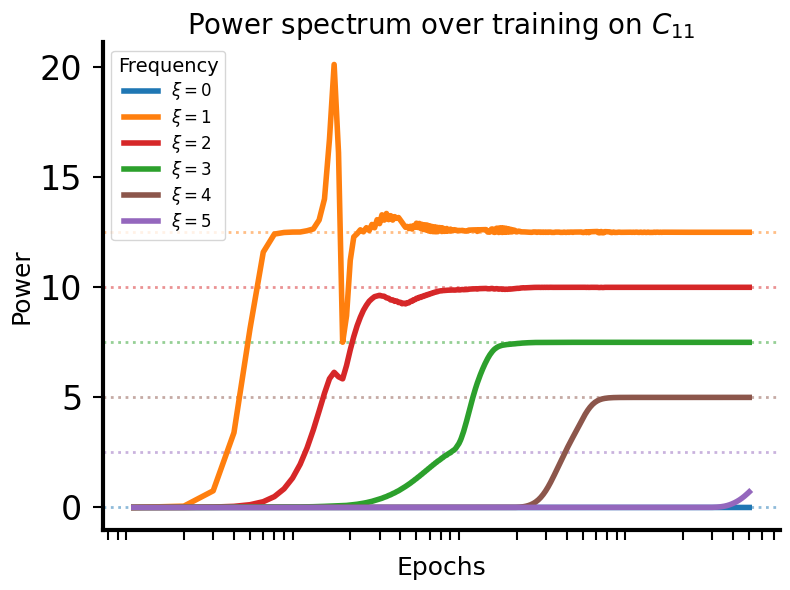

In [8]:
# Compute template power for reference lines
num_freqs = p // 2 + 1
template_ft = np.fft.rfft(tpl)
template_power = np.abs(template_ft)[:num_freqs]

# Compute output power over time
num_points = min(500, len(param_history))
steps = np.unique(np.logspace(0, np.log10(max(1, len(param_history) - 1)), num_points, dtype=int))
powers_over_time = []

for step in steps:
    net.load_state_dict(param_history[step])
    net.eval()
    with torch.no_grad():
        outputs = net(X_tensor)
        ft = np.fft.rfft(outputs.detach().cpu().numpy(), axis=1)
        avg_power = np.mean(np.abs(ft), axis=0)
        powers_over_time.append(avg_power)

powers_over_time = np.array(powers_over_time)

# Plot
colors = ["tab:blue", "tab:orange", "tab:red", "tab:green", "tab:brown", "tab:purple"]
fig, ax = plt.subplots(figsize=(8, 6))

for k in range(num_freqs):
    color = colors[k] if k < len(colors) else f"C{k}"
    ax.plot(steps, powers_over_time[:, k], color=color, lw=4, label=rf"$\xi = {k}$")
    ax.axhline(template_power[k], color=color, linestyle="dotted", linewidth=2, alpha=0.5, zorder=-10)

ax.set_xscale("log")
ax.set_ylabel("Power", fontsize=18)
ax.set_xlabel("Epochs", fontsize=18)
ax.set_title(f"Power spectrum over training on $C_{{{p}}}$", fontsize=20)
ax.legend(fontsize=12, title="Frequency", title_fontsize=14, loc="upper left", labelspacing=0.25)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cn_power_spectrum.pdf", bbox_inches="tight")
plt.show()

## AGF Numerics

Compare gradient descent training with the Alternating Gradient Flow (AGF) approximation.
AGF decomposes training into alternating utility-maximization and cost-minimization phases,
predicting when each Fourier mode activates.

In [9]:
from tqdm import tqdm


class ModsumSubNetwork(nn.Module):
    """A single neuron of the two-layer network for AGF analysis."""

    def __init__(self, d_in, d_out, init_scale):
        super().__init__()
        assert d_in % 2 == 0
        self.p = d_in // 2
        self.u = nn.Linear(self.p, 1, bias=False)
        self.v = nn.Linear(self.p, 1, bias=False)
        self.w = nn.Linear(1, d_out, bias=False)
        with torch.no_grad():
            self.w.weight.mul_(init_scale)
            self.u.weight.mul_(init_scale)
            self.v.weight.mul_(init_scale)
        self.active = False
        self.util_acc = 0
        self.c_a = 1 / self.get_norm() - 1
        self.normalize()

    def get_norm(self):
        sqnorm = lambda x: torch.linalg.norm(x.weight) ** 2
        return torch.sqrt(sqnorm(self.w) + sqnorm(self.u) + sqnorm(self.v))

    def reinitialize(self, u, v, w):
        with torch.no_grad():
            self.u.weight.copy_(u)
            self.v.weight.copy_(v)
            self.w.weight.copy_(w)
        self.c_a = 1 / self.get_norm() - 1

    def forward(self, x):
        x1 = x[:, : self.p]
        x2 = x[:, self.p :]
        return self.w((self.u(x1) + self.v(x2)) ** 2)

    def normalize(self):
        norm = self.get_norm()
        with torch.no_grad():
            self.w.weight.div_(norm)
            self.u.weight.div_(norm)
            self.v.weight.div_(norm)

    def utility_step(self, x, residual, learning_rate):
        f_i = self(x)
        util = torch.einsum("nd,nd->n", f_i, residual).mean()
        self.util_acc += 3 * learning_rate * util.item()
        norm_th = 1 / (1 + self.c_a - self.util_acc)
        util.backward()
        with torch.no_grad():
            self.w.weight += norm_th * learning_rate * self.w.weight.grad
            self.u.weight += norm_th * learning_rate * self.u.weight.grad
            self.v.weight += norm_th * learning_rate * self.v.weight.grad
            self.w.weight.grad.zero_()
            self.u.weight.grad.zero_()
            self.v.weight.grad.zero_()
            self.normalize()


class ModsumNetwork(nn.Module):
    """Network of ModsumSubNetwork neurons for AGF simulation."""

    def __init__(self, d_in, d_out, init_scale, width=100):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.width = width
        neurons = [ModsumSubNetwork(d_in, d_out, init_scale) for _ in range(width)]
        self.neurons = nn.ModuleList(neurons)
        self.set_mode("utilmax")

    def load_init(self, U, V, W):
        for i, n in enumerate(self.neurons):
            u, v, w = U[i], V[i], W[i][:, None]
            n.reinitialize(u, v, w)

    def dormant(self):
        return [neuron for neuron in self.neurons if not neuron.active]

    def set_mode(self, mode):
        if mode not in ["utilmax", "costmin"]:
            raise ValueError("mode must be utilmax or costmin")
        self.mode = mode
        for neuron in self.neurons:
            grad_on = (mode == "utilmax") ^ neuron.active
            for param in neuron.parameters():
                param.requires_grad = grad_on

    def forward(self, x):
        active = [n for n in self.neurons if n.active]
        if not active:
            return torch.zeros(x.shape[0], self.d_out, device=x.device)
        outputs = torch.stack([n(x) for n in active], dim=0)
        return torch.sum(outputs, dim=0)


def train_agf(
    X_train, Y_train, init_sz=1e-3, agf_steps=5, from_init=None,
    utilmax_lr=1, costmin_lr=1, costmin_maxiter=1e4, loss_thresh=1e-4,
):
    """Run the Alternating Gradient Flow (AGF) approximation."""
    d_in, d_out = X_train.shape[-1], Y_train.shape[-1]
    if from_init:
        U, V, W = from_init["U"], from_init["V"], from_init["W"]
        width = U.shape[0]
        agf_net = ModsumNetwork(d_in, d_out, init_sz, width=width)
        agf_net.load_init(U, V, W)
    else:
        agf_net = ModsumNetwork(d_in, d_out, init_sz, width=agf_steps)
    agf_net = agf_net.to(X_train.device)
    X_train.requires_grad = False

    results = {"t": [], "losses": [], "pred": []}

    def update_results(t):
        results["t"].append(t)
        residual = (Y_train - agf_net(X_train)).detach()
        results["losses"].append((residual**2).mean().item())
        results["pred"].append(agf_net(X_train).detach().cpu().clone())

    t = 0
    update_results(t)
    for _ in tqdm(range(agf_steps)):
        residual = (1 / d_out) * 2 * (Y_train - agf_net(X_train))
        residual = residual.detach()
        iters = 0
        mode = "utilmax"
        while mode == "utilmax":
            for n in agf_net.neurons:
                if n.active:
                    continue
                n.utility_step(X_train, residual, utilmax_lr)
                if n.util_acc > n.c_a:
                    n.active = True
                    mode = "costmin"
            iters += 1
        agf_net.set_mode(mode)
        t += iters

        agf_opt = torch.optim.SGD(agf_net.parameters(), lr=costmin_lr, momentum=0.9)
        for _ in range(int(costmin_maxiter)):
            agf_opt.zero_grad(set_to_none=False)
            residual = Y_train - agf_net(X_train)
            loss = (residual**2).mean()
            loss.backward()
            agf_opt.step()
        agf_net.set_mode("utilmax")

        print(f"loss: {loss.item():.5f}")
        update_results(t)

        if not agf_net.dormant() or loss.item() < loss_thresh:
            break

    return results

In [ ]:
# This takes a very long time to run
if not TEST_MODE:
    agf_results = train_agf(
        X_tensor, Y_tensor,
        init_sz=init_scale,
        agf_steps=50,
        from_init=param_history[0],
        utilmax_lr=0.1,
        costmin_lr=0.01,
        costmin_maxiter=1e4,
        loss_thresh=1e-4,
    )
else:
    agf_results = None
    print("Skipping AGF in TEST_MODE")

  0%|          | 0/50 [20:29<?, ?it/s]


KeyboardInterrupt: 

## Loss: GD vs AGF

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(loss_history, lw=4, label="GD")

# Theory plateau levels
for level in theory["levels"]:
    ax.axhline(y=level, color="black", linestyle="--", linewidth=2, zorder=-2)

# AGF overlay
if agf_results is not None:
    utilmax_lr_val = 0.1
    f = utilmax_lr_val / lr
    agf_times = agf_results["t"] + [epochs]
    agf_losses = agf_results["losses"] + [agf_results["losses"][-1]]
    ax.step(f * np.array(agf_times), agf_losses, where="post", lw=2, ls="dashed", color="k", label="AGF")
    ax.legend(fontsize=14)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Epochs", fontsize=18)
ax.set_ylabel("Train Loss", fontsize=18)
ax.set_title(f"GD vs AGF on $C_{{{p}}}$", fontsize=20)
viz.style_axes(ax)
ax.grid(False)

plt.tight_layout()
plt.savefig(f"{FIGURES_DIR}/cn_loss_agf.pdf", bbox_inches="tight")
plt.show()